In [1]:
%reload_kedro

2020-06-08 10:28:14,826 - root - INFO - ** Kedro project Immunization Drop-outs
2020-06-08 10:28:14,827 - root - INFO - Defined global variable `context` and `catalog`


In [2]:
dfp = catalog.load("preprocessed_patients")
dfi = catalog.load("preprocessed_immunization")
dff = catalog.load("facilities")

2020-06-08 10:28:14,833 - kedro.io.data_catalog - INFO - Loading data from `preprocessed_patients` (CSVDataSet)...
2020-06-08 10:28:14,904 - kedro.io.data_catalog - INFO - Loading data from `preprocessed_immunization` (CSVDataSet)...
2020-06-08 10:28:15,021 - kedro.io.data_catalog - INFO - Loading data from `facilities` (CSVDataSet)...


In [3]:
dfi.isnull().sum().sum()

0

In [4]:
dff.isnull().sum().sum()

0

In [5]:
dfp.isnull().sum().sum()

0

In [6]:
set(list(dfp.pat_id.unique())) == set(list(dfi.pat_id.unique()))

False

* OPV (oral polio vaccine):
    * Dose 1: birth
    * Dose 2: 6 weeks
    * Dose 3: 10 weeks,
    * Dose 4: 14 weeks*
* DTP (diphtheria, tetanus, pertussis)​:
    * Dose 1: 6 weeks
    * Dose 2: 10 weeks
    * Dose 3: 14 weeks*
    
Data Dictionary: immunizations_db.csv
* pat_id: The ID of the child.
* vaccine: The abbreviated name of the vaccine the child attempted to receive.
* im_date: Immunization date, i.e. the date the child received the vaccine.
* successful: Whether or not the vaccination was successful.
* reason_unsuccesful: If the vaccination was unsuccessful, the selected reason why.

Data Dictionary: patients_db.csv
* pat_id: The unique ID of the child.
* dob: The date of birth of the child.
* gender: The gender of the child.
* fac_id: The unique ID of the health facility the child received the vaccination.
* lat: The latitude of the facility.
* long: The longitude of the facility.
* district: The geographical district that the facility is located in.

First lets see how many vaccines each child received.

In [7]:
dfi.head()

,pat_id,vaccine,im_date
0,1,OPV,2019-01-31
1,1,OPV,2019-04-03
2,1,OPV,2019-05-25
3,1,OPV,2019-07-06
4,1,DTP,2019-04-03


If I had more time, for labelling I would use snorkel (https://www.snorkel.org/) to label and manage this dataset. Here I will assign two labels:
* high_risk
* low_risk

After getting more familiar with the nature of the problem, researching the topic and interviewing health workers I would definitely add more labels. Ideally, labelling would be done by a healthcare worker (someone with domain knowledge) or the data would have information if there was an intervention and at what time. Here, I have to asign labels based on my limited knowledge of the subject. The posibility of `garbage-in garbage-out` outcome is very high for that reason.

In [8]:
len(set(list(dfp.pat_id.unique())) - set(list(dfi.pat_id.unique())))

1106

There are 1106 patients without immunizations records. I will treat it as data capture mistake as each child should receive a vaccine at birth. If I had more time I would investigate if those records come from specific district etc. 

In [9]:
bad_pat_id = list(set(list(dfp.pat_id.unique())) - set(list(dfi.pat_id.unique())))
dfp = dfp[~dfp.pat_id.isin(bad_pat_id)]

In [10]:
def remove_bad_pat_id(df0, df1):
    """
    Remove patients without immunizations records.
    """
    bad_pat_id = list(set(list(df0.pat_id.unique())) - set(list(df1.pat_id.unique())))
    return df0[~df0.pat_id.isin(bad_pat_id)]

First I will join all my processed datasets.

In [11]:
dfp.head()

,pat_id,fac_id,dob,gender,long,lat,region,district
0,1,51.0,2019-01-22,f,21.678399,-21.739251,Ghanzi,Ghanzi
1,2,89.0,2019-11-12,f,24.877556,-18.370709,Chobe,Chobe
2,3,161.0,2019-11-03,m,25.249672,-20.490189,Central,Tutume
3,4,168.0,2019-04-17,f,25.579269,-21.412151,Central,Lethlakane
4,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli


In [12]:
import pandas as pd

In [13]:
# df_outer = pd.merge(dfi, dfp, on='pat_id', how='outer')
# df_outer.head()

In [14]:
def build_primary_table(df0, df1):
    """
    Join preprocessed_patients and preprocessed_immunization
    dataframes. Drop successful == False records.
    """
    df = pd.merge(df0, df1, on='pat_id', how='outer')
    df = df.reset_index(drop=True)
    return df

In [15]:
df_outer = build_primary_table(dfp, dfi)

In [16]:
df_outer.isnull().sum().sum()

0

In [17]:
df_outer[df_outer.pat_id == 2].sort_values('im_date')

,pat_id,fac_id,dob,gender,long,lat,region,district,vaccine,im_date
7,2,89.0,2019-11-12,f,24.877556,-18.370709,Chobe,Chobe,OPV,2019-11-12


## Features

For my list of predictors I will use:
* Gender
* Facility
* Region
* First vaccine type
* Enrollment age in weeks
* Exit age in weeks
* Vaccine timeliness (on-time, late, early) <- if I had input from a health worker on how to define those 


Create feature dataframe:

In [18]:
pat_id = list(df_outer.pat_id.unique())

In [19]:
dfp[dfp.pat_id == 1].iloc[-1].gender

'f'

In [20]:
def extract_temp_df(df, pid):
    """
    Extract all records for a patient from the primary table
    and sort by immunization date.
    """
    df = df[df.pat_id == pid].sort_values('im_date')
    df['im_date'] = pd.to_datetime(df['im_date'], format='%Y-%m-%d')
    df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')
    return df

In [21]:
# test df
test_df = extract_temp_df(df_outer, 5)
test_df

,pat_id,fac_id,dob,gender,long,lat,region,district,vaccine,im_date
18,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,2018-12-24
19,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,2019-02-10
22,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,DTP,2019-02-10
20,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,2019-03-18
23,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,DTP,2019-03-18
21,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,2019-04-27


In [22]:
test_df['im_date'].idxmin()

18

In [23]:
test_df.vaccine.loc[18]

'OPV'

In [24]:
import math
import numpy as np

In [25]:
def date2weeks(im_date, dob):
    """
    im_date, dob in datetime format
    """
    return math.floor(((im_date - dob) / np.timedelta64(1, 'W')))

In [26]:
test_df['im_date'] = test_df.apply(lambda x: date2weeks(x.im_date, x.dob), axis=1)
test_df

,pat_id,fac_id,dob,gender,long,lat,region,district,vaccine,im_date
18,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,2
19,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,9
22,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,DTP,9
20,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,14
23,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,DTP,14
21,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,OPV,20


In [27]:
test_df[(test_df.vaccine == 'OPV') & (test_df.im_date <= 16)].shape[0]

3

In [28]:
def feature_first_vaccine(df):
    """
    First vaccine, accepts temporarys dataframe for 
    a patient.
    """
    idx = df['im_date'].idxmin()
    return df.vaccine.loc[idx]

In [29]:
def feature_enrollment_age(df):
    """
    Enrollment age in weeks.
    """
    return math.floor(((df.im_date.min() - df.dob.min()) / np.timedelta64(1, 'W')))

In [30]:
def feature_exit_age(df):
    """
    Exit age in weeks.
    """
    return math.floor(((df.im_date.max() - df.dob.min()) / np.timedelta64(1, 'W')))

In [31]:
def feature_opv_by_4mths(df):
    """
    Number of OPV vaccines received by 4 months
    4 months == 16 weeks
    """
    return df[(df.vaccine == 'OPV') & (df.im_date <= 16)].shape[0]

In [32]:
def feature_opv_by_6mths(df):
    """
    Number of OPV vaccines received by 4 months
    6 months == 24 weeks
    """
    return df[(df.vaccine == 'OPV') & (df.im_date <= 24)].shape[0]

In [33]:
def feature_dtp_by_4mths(df):
    """
    Number of OPV vaccines received by 4 months
    4 months == 16 weeks
    """
    return df[(df.vaccine == 'DTP') & (df.im_date <= 16)].shape[0]

In [34]:
def feature_dtp_by_6mths(df):
    """
    Number of OPV vaccines received by 4 months
    6 months == 24 weeks
    """
    return df[(df.vaccine == 'DTP') & (df.im_date <= 24)].shape[0]

* OPV (oral polio vaccine):
    * Dose 1: birth
    * Dose 2: 6 weeks
    * Dose 3: 10 weeks,
    * Dose 4: 14 weeks*
* DTP (diphtheria, tetanus, pertussis)​:
    * Dose 1: 6 weeks
    * Dose 2: 10 weeks
    * Dose 3: 14 weeks*

In [35]:
import numpy as np

In [36]:
def build_feature_table(primary_table):
    """
    Features:
        Gender
        Facility
        Region
        First vaccine type
        Enrollment age in weeks
        Exit age in weeks
        Number of OPV vaccines received by 4 months
        Number of OPV vaccines received by 6 months
        Number of DTP vaccines received by 4 months
        Number of DTP vaccines received by 6 months
    """
    pat_id = list(primary_table.pat_id.unique())
    feature_df_list = []
    for p in pat_id:
        pat_dict = dict()
        pat_dict['pat_id'] = p

        pat_df = extract_temp_df(primary_table, p)

        facility = pat_df.iloc[-1].fac_id
        pat_dict['facility'] = facility

        region = pat_df.iloc[-1].region
        pat_dict['region'] = region

        gender = pat_df.iloc[-1].gender
        pat_dict['gender'] = gender

        vaccine = feature_first_vaccine(pat_df)
        pat_dict['first_vaccine'] = vaccine

        pat_df['im_date'] = pat_df.apply(lambda x: date2weeks(x.im_date, x.dob), axis=1)
        pat_dict['enrollment_age'] = pat_df.im_date.min()
        pat_dict['exit_age'] = pat_df.im_date.max()

        pat_dict['opv_by_4mths'] = feature_opv_by_4mths(pat_df)
        pat_dict['opv_by_6mths'] = feature_opv_by_6mths(pat_df)
        pat_dict['dtp_by_4mths'] = feature_dtp_by_4mths(pat_df)
        pat_dict['dtp_by_6mths'] = feature_dtp_by_6mths(pat_df)

        feature_df_list.append(pat_dict)

    return pd.DataFrame(feature_df_list)

In [37]:
# feature_df_list = []
# for p in pat_id:
    
#     pat_dict = dict()
#     pat_dict['pat_id'] = p
    
#     pat_df = extract_temp_df(df_outer, p)
    
#     facility = pat_df.iloc[-1].fac_id
#     pat_dict['facility'] = facility
    
#     region = pat_df.iloc[-1].region
#     pat_dict['region'] = region
    
#     gender = pat_df.iloc[-1].gender
#     pat_dict['gender'] = gender
    
#     vaccine = feature_first_vaccine(pat_df)
#     pat_dict['first_vaccine'] = vaccine
    
#     pat_df['im_date'] = pat_df.apply(lambda x: date2weeks(x.im_date, x.dob), axis=1)
#     pat_dict['enrollment_age'] = pat_df.im_date.min()
#     pat_dict['exit_age'] = pat_df.im_date.max()
    
#     pat_dict['opv_by_4mths'] = feature_opv_by_4mths(pat_df)
#     pat_dict['opv_by_6mths'] = feature_opv_by_6mths(pat_df)
#     pat_dict['dtp_by_4mths'] = feature_dtp_by_4mths(pat_df)
#     pat_dict['dtp_by_6mths'] = feature_dtp_by_6mths(pat_df)
    
#     feature_df_list.append(pat_dict)

feature_df = build_feature_table(df_outer)

feature_df.head()

,pat_id,facility,region,gender,first_vaccine,enrollment_age,exit_age,opv_by_4mths,opv_by_6mths,dtp_by_4mths,dtp_by_6mths
0,1,51.0,Ghanzi,f,OPV,1,23,2,4,1,3
1,2,89.0,Chobe,f,OPV,0,0,1,1,0,0
2,3,161.0,Central,m,OPV,0,6,2,2,1,1
3,4,168.0,Central,f,OPV,6,34,1,2,1,1
4,5,183.0,Central,m,OPV,2,20,3,4,2,2


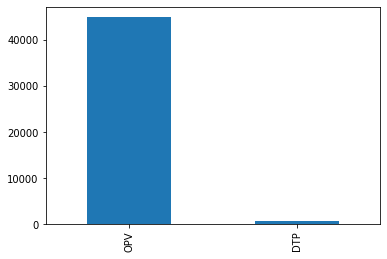

In [38]:
feature_df['first_vaccine'].value_counts().plot(kind='bar')

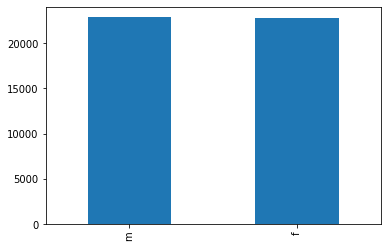

In [39]:
feature_df['gender'].value_counts().plot(kind='bar')

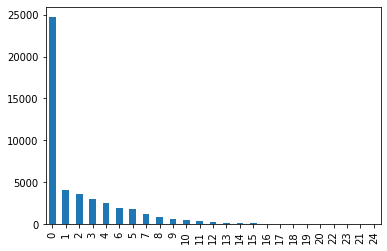

In [40]:
feature_df['enrollment_age'].value_counts().plot(kind='bar')

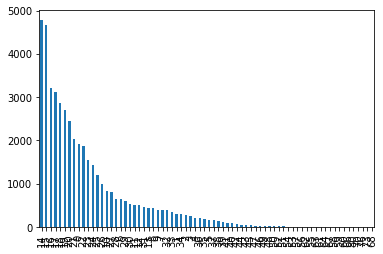

In [41]:
feature_df['exit_age'].value_counts().plot(kind='bar')

In [42]:
feature_df.shape

(45675, 11)